### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/Challenge1/changed dataset

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/Challenge1/changed dataset


### Import libraries

In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [4]:
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


# Load and process data

In [ ]:
# Conditional check for unzipping
unzip = True

# Unzip the 'public_data.npz' file if the 'unzip' flag is True
if unzip:
    !unzip changed_data.npz

# Unzip the 'public_data.npz' file if the 'unzip' flag is True
    !unzip changed_data.npz

Archive:  changed_data.npz
 extracting: data_del.npy            
 extracting: lab_del.npy             
Archive:  changed_data.npz
replace data_del.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: data_del.npy            A

 extracting: lab_del.npy             


In [5]:
file1_data = np.load('data_del.npy',allow_pickle=True)
file2_labels = np.load('lab_del.npy',allow_pickle=True)
print(file1_data.shape)
print(file2_labels.shape, 'is in the wrong shape !')

(5004, 96, 96, 3)
(5004,) is in the wrong shape !


In [6]:
# use 0 and 1 for classes and adjust the labels in the format (row, 1)

label_encoder = LabelEncoder()
file2_labels = label_encoder.fit_transform(file2_labels)
print(file2_labels.shape)

file2_labels= file2_labels.reshape(-1, 1) # -1 is to use number of row of total element
print(file2_labels.shape)
print(file2_labels[:3])


(5004,)
(5004, 1)
[[0]
 [0]
 [0]]


In [7]:
labels={0:'healty', 1:'unhealty'}

In [8]:
#Normlaize images in [0,1]
#file1_data=(file1_data/255).astype('float32')
file1_data=(file1_data/255)

[1]


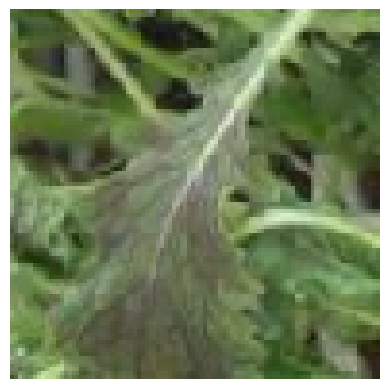

In [9]:
index = 14  # Example: display an image

image = file1_data[index]  # Select the image

# View with matplotlib
plt.imshow(image)
plt.axis('off')
print(file2_labels[index])

plt.show()

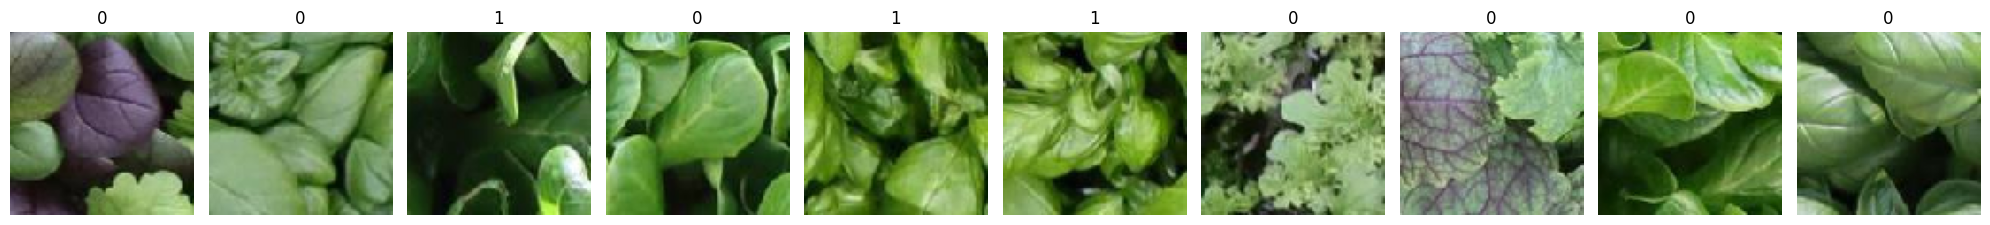

In [10]:
#visualization of 10 random images and their labels
num_img = 10
fig, axes = plt.subplots(1, num_img, figsize=(20, 9))

for i in range(num_img):
    index=random.randrange(0,len(file1_data)-1)
    ax = axes[i]
    ax.imshow(np.clip(file1_data[index], 0, 255))
    ax.set_title(file2_labels[index,0])
    ax.axis('off')

plt.tight_layout()
plt.show()


In [11]:
#Visualize the class distribution with pandas dataframe
dataframe=pd.DataFrame(file2_labels, columns=['class'])
print(dataframe['class'].value_counts())

0    3101
1    1903
Name: class, dtype: int64


In [12]:
#split the data in train_val e test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    file1_data,
    file2_labels,
    test_size=0.1,    # 10%
    random_state=seed,
    stratify=dataframe
)

#further split into train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=len(X_test),  #test and validation set of same dimension
    random_state=seed,
    stratify=y_train_val
)

print("X_train shape & y_train shape")
print(X_train.shape, y_train.shape)
print("\nX_val shape & y_val shape")
print(X_val.shape, y_val.shape)
print("\nX_test shape & y_test shape")
print(X_test.shape, y_test.shape)

X_train shape & y_train shape
(4002, 96, 96, 3) (4002, 1)

X_val shape & y_val shape
(501, 96, 96, 3) (501, 1)

X_test shape & y_test shape
(501, 96, 96, 3) (501, 1)


In [13]:
# I use the to_categorical function for one-hot encoding

y_train_val=tfk.utils.to_categorical(y_train_val)
y_train=tfk.utils.to_categorical(y_train)
y_val=tfk.utils.to_categorical(y_val)
y_test=tfk.utils.to_categorical(y_test)

print(y_train.shape)
print("\nFirst 5 values of y_train")
print(y_train[:5])

(4002, 2)

First 5 values of y_train
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


# Define model, train, inference

In [14]:
#key model parameters
input_shape=X_train_val.shape[1:] #(96, 96, 3)
output_shape=y_train.shape[1]     #2
batch_size=32
epochs=500

In [15]:
# Define the model

def build_model(input_shape=input_shape, output_shape=output_shape):
    tf.random.set_seed(seed)

    # Build the neural network
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(input_layer)
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)

    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.ReLU(name='relu4')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    # Output layer with 2 neurons and softmax fx.
    output_layer = tfkl.Dense(units=2, activation='softmax',name='Output')(x)

    # Connect input and output
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model

In [16]:
# Build the model and display its summary
model = build_model(input_shape, output_shape)
model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv0 (Conv2D)              (None, 96, 96, 32)        896       
                                                                 
 relu0 (ReLU)                (None, 96, 96, 32)        0         
                                                                 
 mp0 (MaxPooling2D)          (None, 48, 48, 32)        0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 64)        18496     
                                                                 
 relu1 (ReLU)                (None, 48, 48, 64)        0         
                                                                 
 mp1 (MaxPooling2D)          (None, 24, 24, 64)        0       

In [17]:
print(X_train.shape)
print(y_train.shape)

(4002, 96, 96, 3)
(4002, 2)


In [18]:
# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, mode='max', restore_best_weights=True)

# Train the model and save its history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
).history


Epoch 1/500
126/126 [==============================] - 16s 27ms/step - loss: 0.6703 - accuracy: 0.6182 - val_loss: 0.6619 - val_accuracy: 0.6208
Epoch 2/500
126/126 [==============================] - 2s 17ms/step - loss: 0.6466 - accuracy: 0.6364 - val_loss: 0.6320 - val_accuracy: 0.6387
Epoch 3/500
126/126 [==============================] - 2s 17ms/step - loss: 0.6128 - accuracy: 0.6829 - val_loss: 0.5773 - val_accuracy: 0.6986
Epoch 4/500
126/126 [==============================] - 2s 17ms/step - loss: 0.5762 - accuracy: 0.7156 - val_loss: 0.5620 - val_accuracy: 0.7146
Epoch 5/500
126/126 [==============================] - 2s 17ms/step - loss: 0.5627 - accuracy: 0.7206 - val_loss: 0.5545 - val_accuracy: 0.7246
Epoch 6/500
126/126 [==============================] - 2s 16ms/step - loss: 0.5428 - accuracy: 0.7381 - val_loss: 0.6022 - val_accuracy: 0.6966
Epoch 7/500
126/126 [==============================] - 2s 19ms/step - loss: 0.5432 - accuracy: 0.7414 - val_loss: 0.5348 - val_accuracy

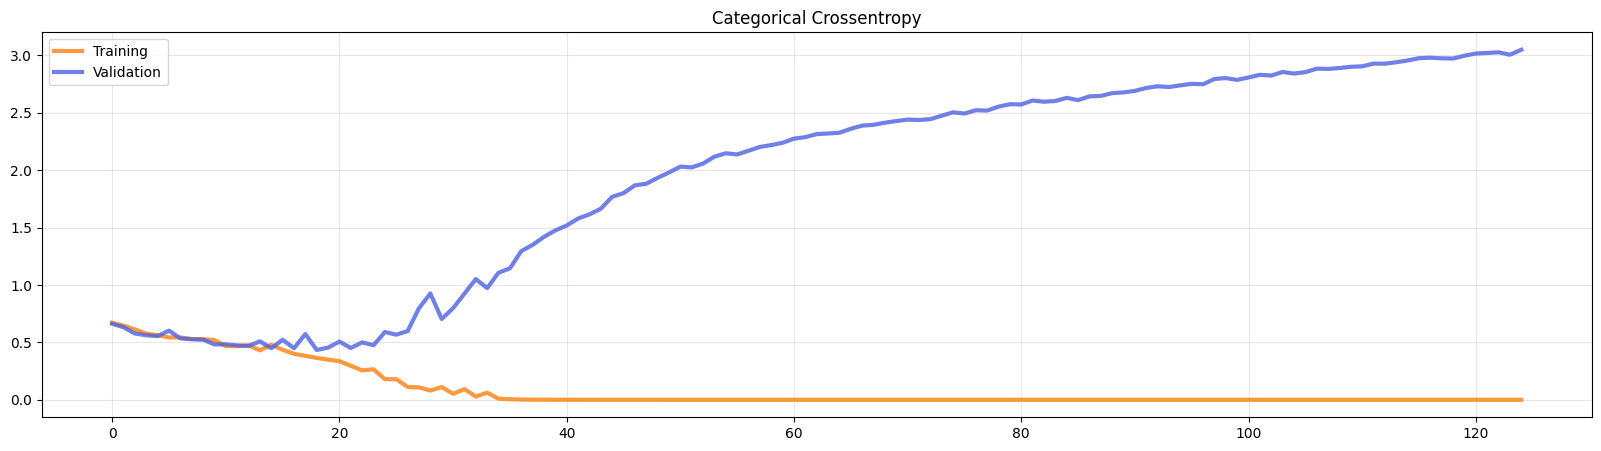

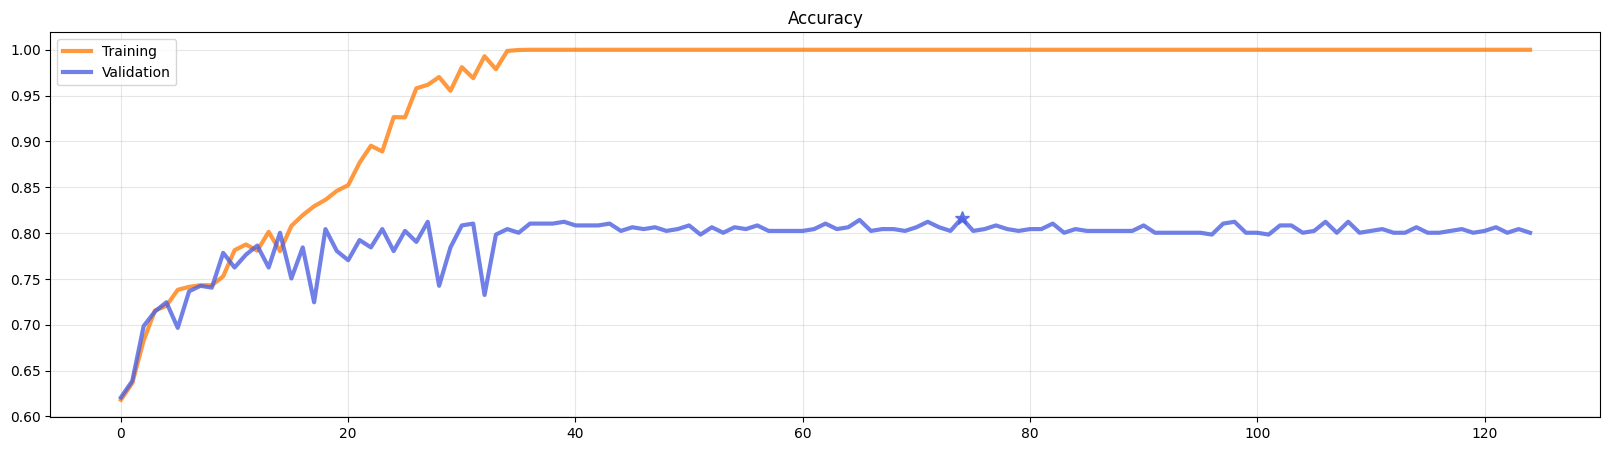

In [19]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

Input image


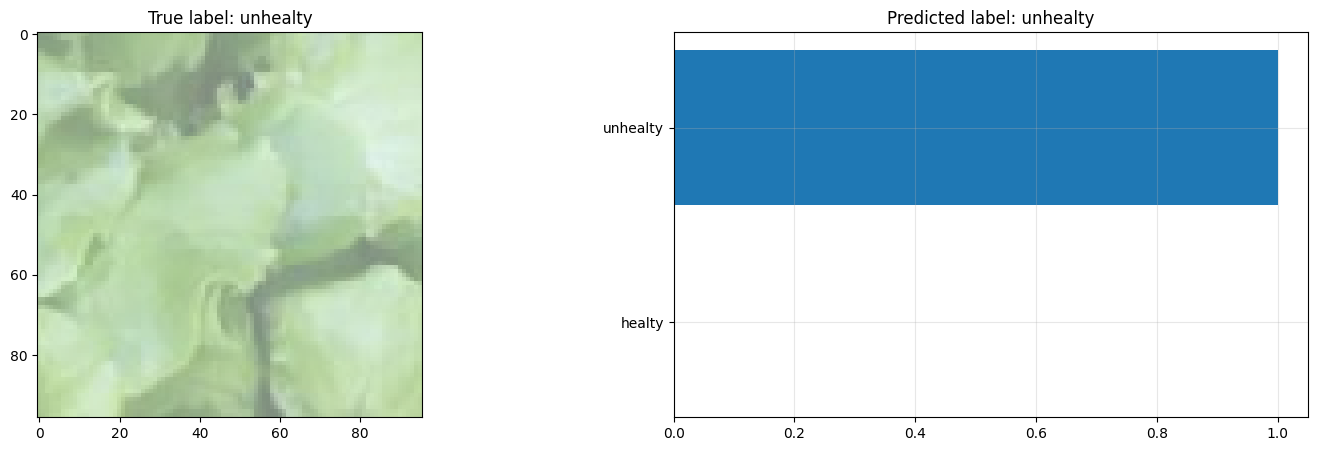

In [20]:
# Choose a random image for visualization
image = np.random.randint(0, len(X_test)-1)

# Display the input image, true label, and predicted label
print('Input image')
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 5)
ax1.imshow((X_test[image] + 1) / 2)
ax1.set_title('True label: ' + labels[np.argmax(y_test[image])])
prediction = model.predict(np.expand_dims(X_test[image], axis=0), verbose=0)
ax2.barh(list(labels.values()), np.squeeze(prediction, axis=0), color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: ' + labels[np.argmax(prediction)])
ax2.grid(alpha=0.3)
plt.show()

In [ ]:
# Make inference

In [21]:
# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (501, 2)


Accuracy: 0.8443
Precision: 0.8438
Recall: 0.8219
F1: 0.8301


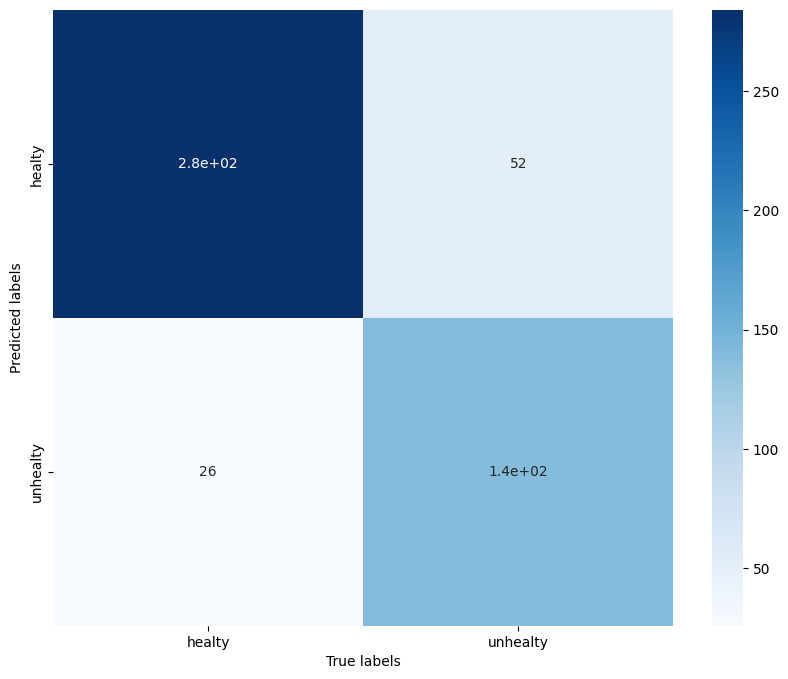

In [22]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
#save the model
model.save('CustomCNN_saved')

# Decrease patience, remove mp3 and conv4

In [23]:
def build_model(input_shape=input_shape, output_shape=output_shape):
    tf.random.set_seed(seed)

    # WE ALSO TRIED TO VARY THE KERNEL_SIZE = 5 and 9

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(input_layer)
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)
    #x = tfkl.MaxPooling2D(name='mp3')(x)

    #x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv4')(x)
    #x = tfkl.ReLU(name='relu4')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    # Output layer with 2 neurons and softmax fx.
    output_layer = tfkl.Dense(units=2, activation='softmax',name='Output')(x)

    # Connect input and output
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model

In [24]:
# Build the model and display its summary
model = build_model(input_shape, output_shape)
model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv0 (Conv2D)              (None, 96, 96, 32)        896       
                                                                 
 relu0 (ReLU)                (None, 96, 96, 32)        0         
                                                                 
 mp0 (MaxPooling2D)          (None, 48, 48, 32)        0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 64)        18496     
                                                                 
 relu1 (ReLU)                (None, 48, 48, 64)        0         
                                                                 
 mp1 (MaxPooling2D)          (None, 24, 24, 64)        0       

In [25]:
# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, mode='max', restore_best_weights=True)

# Train the model and save its history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
).history


Epoch 1/500
126/126 [==============================] - 3s 16ms/step - loss: 0.6738 - accuracy: 0.6197 - val_loss: 0.6642 - val_accuracy: 0.6208
Epoch 2/500
126/126 [==============================] - 2s 15ms/step - loss: 0.6466 - accuracy: 0.6437 - val_loss: 0.6240 - val_accuracy: 0.6427
Epoch 3/500
126/126 [==============================] - 2s 15ms/step - loss: 0.6256 - accuracy: 0.6654 - val_loss: 0.6041 - val_accuracy: 0.6906
Epoch 4/500
126/126 [==============================] - 2s 15ms/step - loss: 0.5903 - accuracy: 0.6924 - val_loss: 0.5877 - val_accuracy: 0.6966
Epoch 5/500
126/126 [==============================] - 2s 14ms/step - loss: 0.5842 - accuracy: 0.7091 - val_loss: 0.5762 - val_accuracy: 0.6966
Epoch 6/500
126/126 [==============================] - 2s 13ms/step - loss: 0.5756 - accuracy: 0.7084 - val_loss: 0.5692 - val_accuracy: 0.7126
Epoch 7/500
126/126 [==============================] - 2s 14ms/step - loss: 0.5668 - accuracy: 0.7139 - val_loss: 0.5528 - val_accuracy:

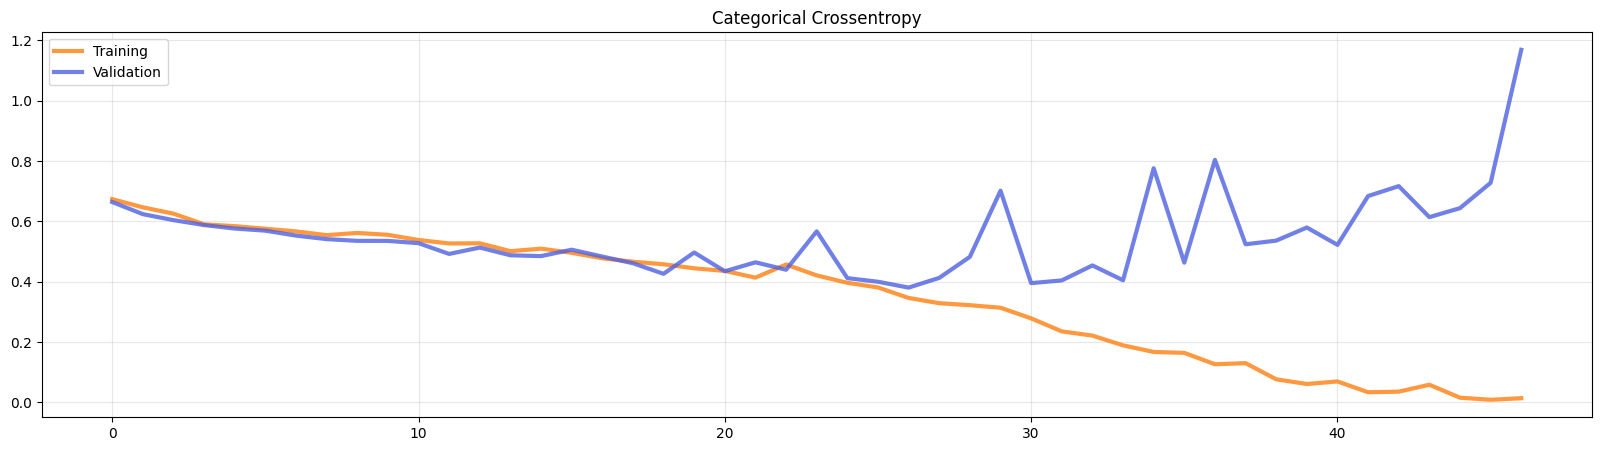

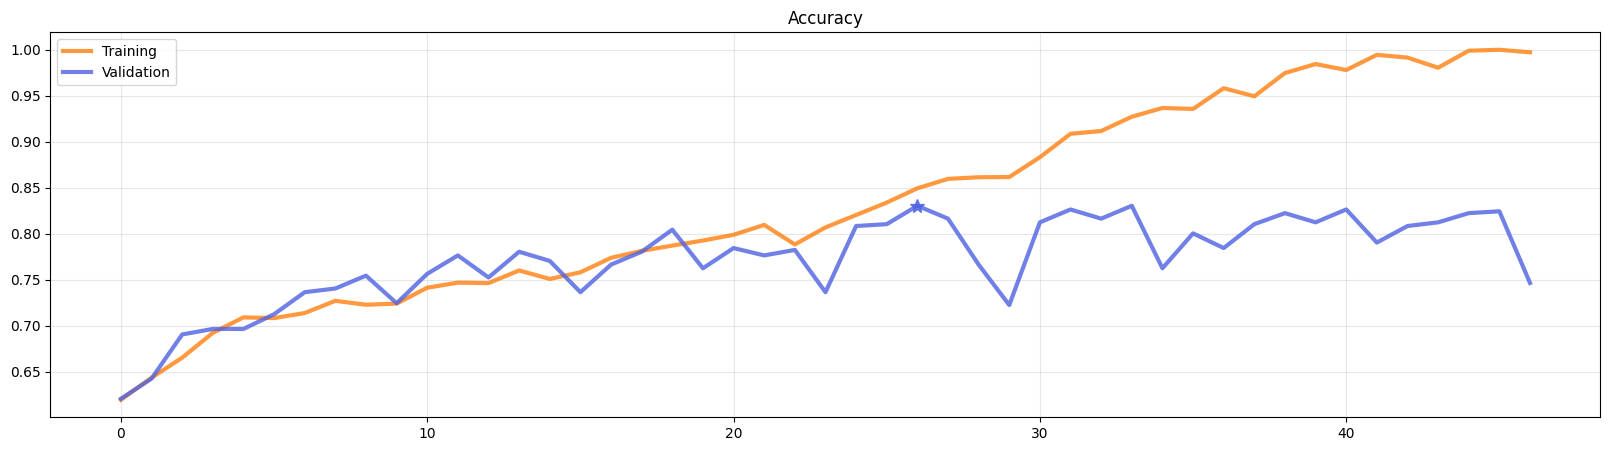

In [26]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
# Make inference

In [28]:
# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (501, 2)


Accuracy: 0.8263
Precision: 0.8322
Recall: 0.7954
F1: 0.8066


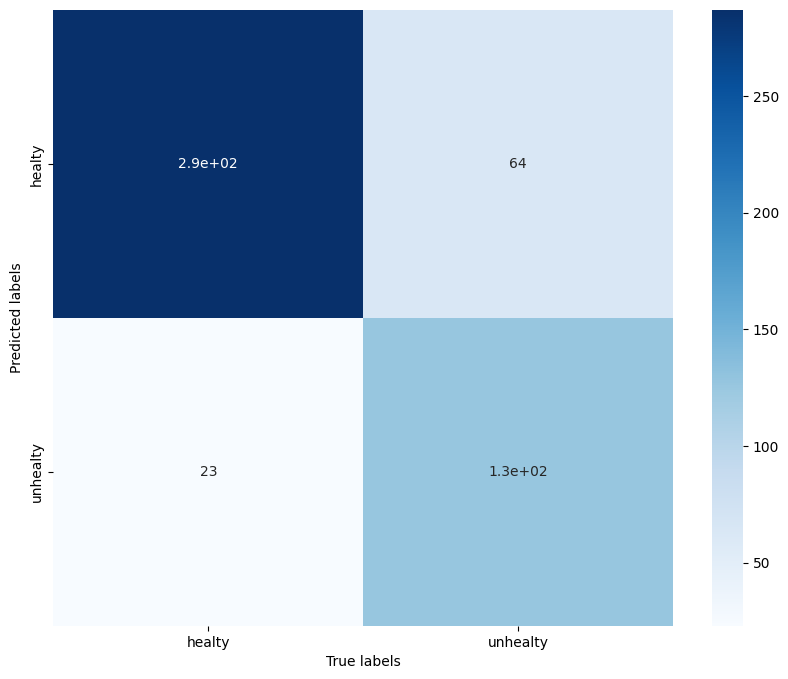

In [29]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Add dynamic learning rate

In [27]:
lr_patience = 5
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',     # Metric to monitor
    patience=lr_patience,       # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.999,               # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='min',                 # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-5                 # Minimum learning rate
)

In [30]:
def build_model(input_shape=input_shape, output_shape=output_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(input_layer)
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)

    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.ReLU(name='relu4')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    output_layer = tfkl.Dense(units=2, activation='softmax',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model

In [31]:
# Build the quasiVGG9 model and display its summary
model = build_model(input_shape, output_shape)
model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv0 (Conv2D)              (None, 96, 96, 32)        896       
                                                                 
 relu0 (ReLU)                (None, 96, 96, 32)        0         
                                                                 
 mp0 (MaxPooling2D)          (None, 48, 48, 32)        0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 64)        18496     
                                                                 
 relu1 (ReLU)                (None, 48, 48, 64)        0         
                                                                 
 mp1 (MaxPooling2D)          (None, 24, 24, 64)        0       

In [32]:
# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, mode='max', restore_best_weights=True)

# Train the model and save its history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
).history


Epoch 1/500
126/126 [==============================] - 4s 19ms/step - loss: 0.6720 - accuracy: 0.6197 - val_loss: 0.6716 - val_accuracy: 0.6208 - lr: 0.0010
Epoch 2/500
126/126 [==============================] - 2s 16ms/step - loss: 0.6557 - accuracy: 0.6354 - val_loss: 0.6638 - val_accuracy: 0.6208 - lr: 0.0010
Epoch 3/500
126/126 [==============================] - 2s 16ms/step - loss: 0.6589 - accuracy: 0.6254 - val_loss: 0.6473 - val_accuracy: 0.6248 - lr: 0.0010
Epoch 4/500
126/126 [==============================] - 2s 18ms/step - loss: 0.6121 - accuracy: 0.6819 - val_loss: 0.5928 - val_accuracy: 0.6826 - lr: 0.0010
Epoch 5/500
126/126 [==============================] - 2s 18ms/step - loss: 0.5944 - accuracy: 0.6914 - val_loss: 0.5841 - val_accuracy: 0.6866 - lr: 0.0010
Epoch 6/500
126/126 [==============================] - 2s 17ms/step - loss: 0.5736 - accuracy: 0.7096 - val_loss: 0.5759 - val_accuracy: 0.7046 - lr: 0.0010
Epoch 7/500
126/126 [==============================] - 2s 

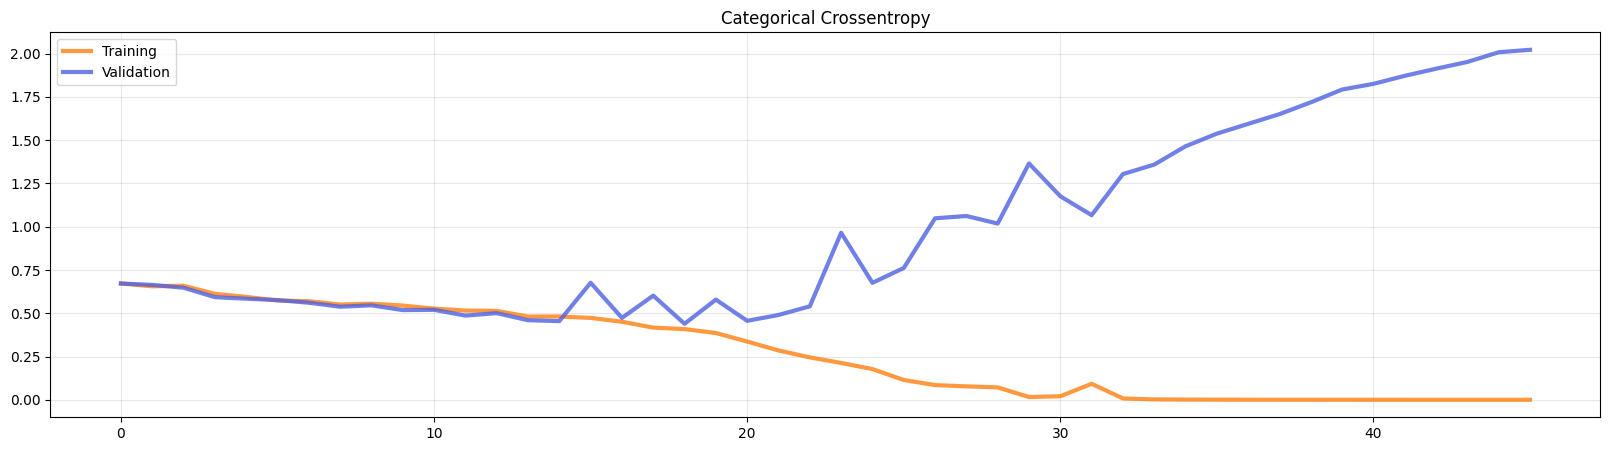

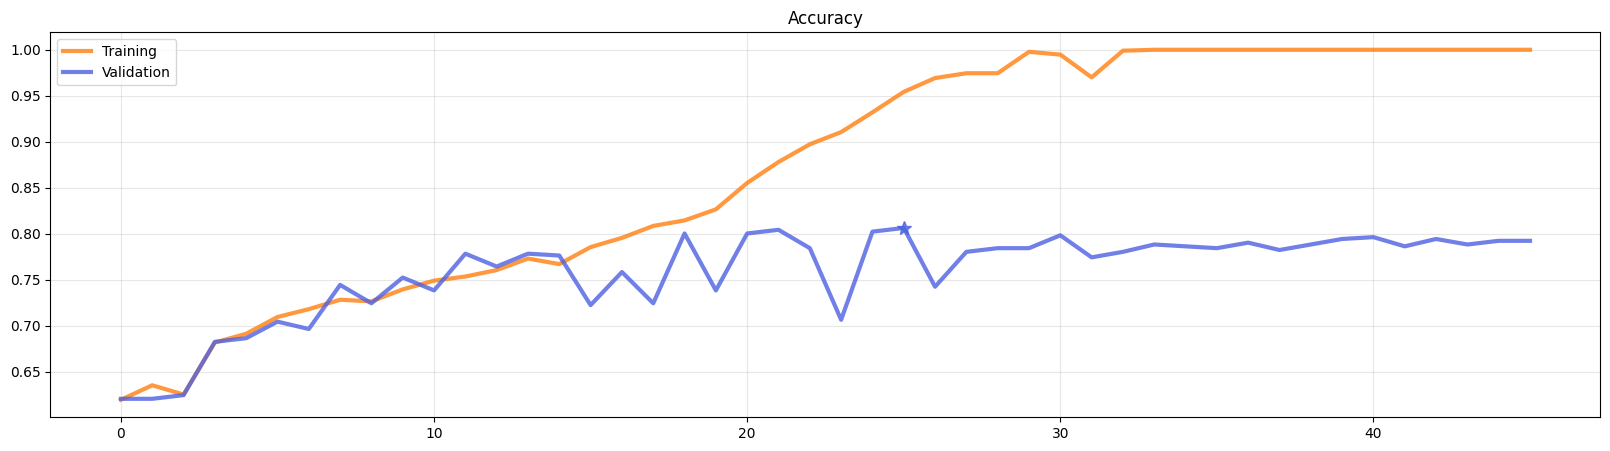

In [33]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

# Add Drop out and AdamW

In [34]:
lr_patience = 5
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',     # Metric to monitor
    patience=lr_patience,       # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.999,               # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='min',                 # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-5                 # Minimum learning rate
)

In [35]:
def build_model(input_shape=input_shape, output_shape=output_shape):
    tf.random.set_seed(seed)

    # WE ALSO TRIED DIFFERENT VALUES FOR DROPOUT RATE (FROM 0.17 TO 0.35)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(input_layer)
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)
    x = tfkl.Dropout(0.25, name='dropout0')(x)  # Aggiunto il layer di dropout

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)
    x = tfkl.Dropout(0.25, name='dropout1')(x)  # Aggiunto il layer di dropout

    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)
    x = tfkl.Dropout(0.25, name='dropout2')(x)  # Aggiunto il layer di dropout

    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)
    #x = tfkl.Dropout(0.25, name='dropout3')(x)  # WITHOUT THIS LAST DROPOUT WE HAVE SEEN SLIGHTLY BETTER RESULTS


    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.ReLU(name='relu4')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    output_layer = tfkl.Dense(units=2, activation='softmax',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # WE TRIED DIFFERENT VALUES FOR LEARNING RATE (FROM 10^-3 TO 10^-4) AND WEIGHT_DECAY (5*10^-4)

    # Compile the model
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate=1e-3, weight_decay=5e-4), metrics=['accuracy'])


    # Return the model
    return model

In [36]:
# Build the model and display its summary
model = build_model(input_shape, output_shape)
model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv0 (Conv2D)              (None, 96, 96, 32)        896       
                                                                 
 relu0 (ReLU)                (None, 96, 96, 32)        0         
                                                                 
 mp0 (MaxPooling2D)          (None, 48, 48, 32)        0         
                                                                 
 dropout0 (Dropout)          (None, 48, 48, 32)        0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 64)        18496     
                                                                 
 relu1 (ReLU)                (None, 48, 48, 64)        0       

In [37]:
# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, mode='max', restore_best_weights=True)

# Train the model and save its history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
).history


Epoch 1/500
126/126 [==============================] - 6s 25ms/step - loss: 0.6752 - accuracy: 0.6182 - val_loss: 0.6782 - val_accuracy: 0.6208 - lr: 0.0010
Epoch 2/500
126/126 [==============================] - 4s 31ms/step - loss: 0.6653 - accuracy: 0.6197 - val_loss: 0.6512 - val_accuracy: 0.6208 - lr: 0.0010
Epoch 3/500
126/126 [==============================] - 3s 20ms/step - loss: 0.6425 - accuracy: 0.6477 - val_loss: 0.6329 - val_accuracy: 0.6507 - lr: 0.0010
Epoch 4/500
126/126 [==============================] - 3s 20ms/step - loss: 0.6253 - accuracy: 0.6714 - val_loss: 0.6277 - val_accuracy: 0.6766 - lr: 0.0010
Epoch 5/500
126/126 [==============================] - 3s 20ms/step - loss: 0.6157 - accuracy: 0.6794 - val_loss: 0.6109 - val_accuracy: 0.6786 - lr: 0.0010
Epoch 6/500
126/126 [==============================] - 3s 22ms/step - loss: 0.5909 - accuracy: 0.6979 - val_loss: 0.5588 - val_accuracy: 0.7285 - lr: 0.0010
Epoch 7/500
126/126 [==============================] - 3s 

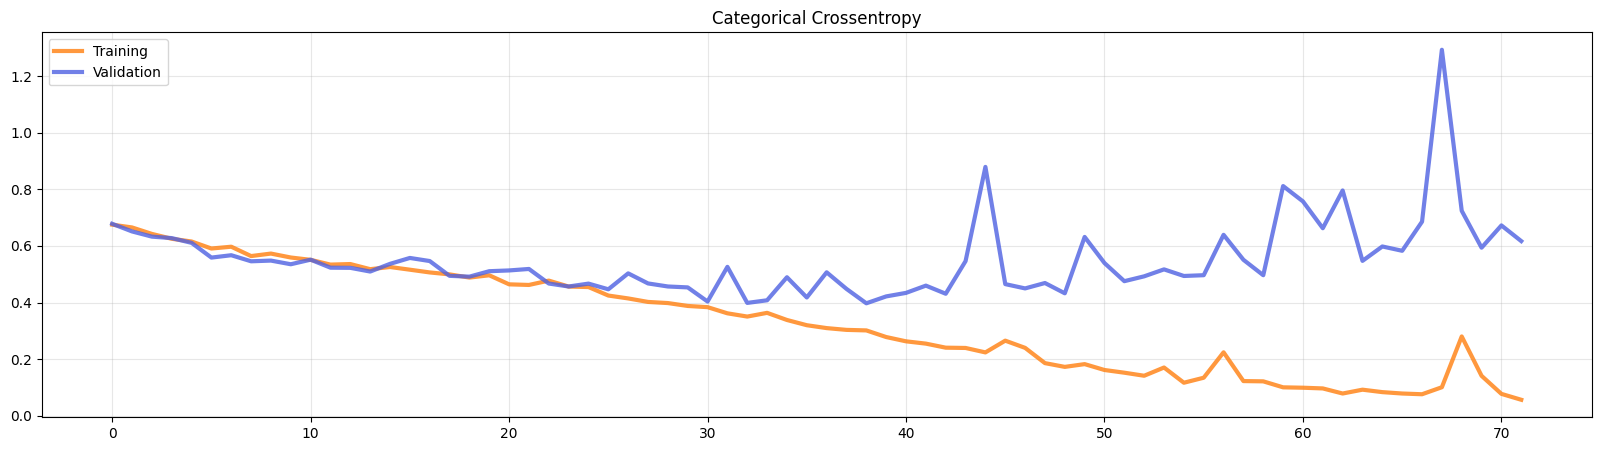

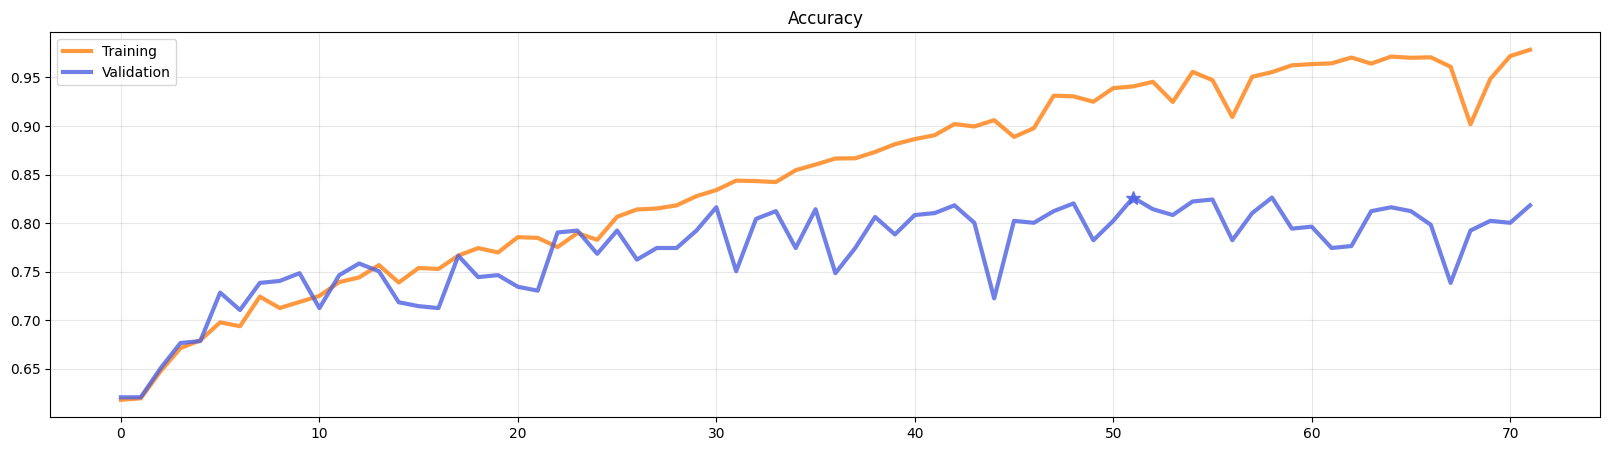

In [38]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
# MAKE INFERENCE #

In [39]:
# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (501, 2)


Accuracy: 0.7984
Precision: 0.7896
Recall: 0.7768
F1: 0.7819


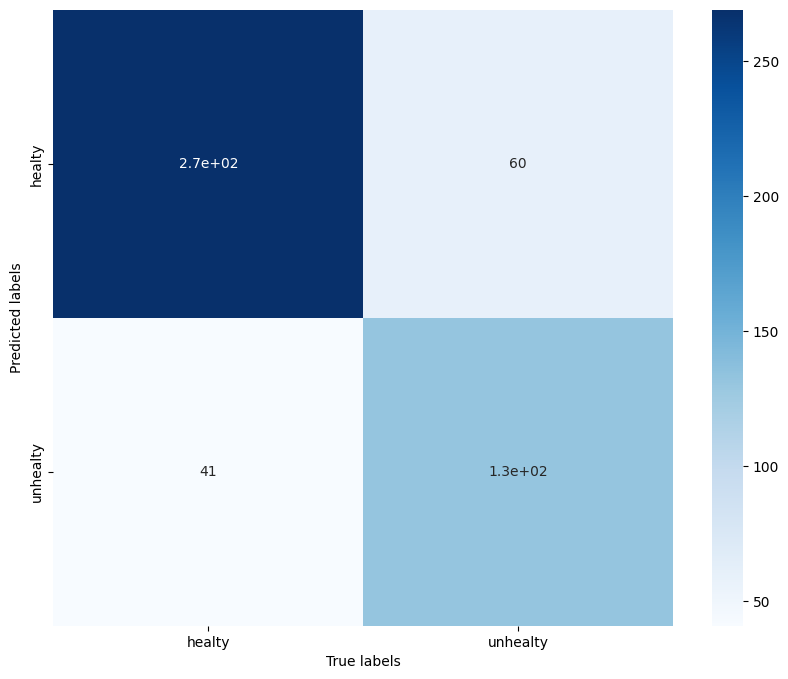

In [40]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
model.save('CustomCNN_saved')

# With Sigmoid as output fx.


In [ ]:
# I have to reload the data because I don't have to use to_categorical in this case

In [45]:
file1_data = np.load('data_del.npy',allow_pickle=True)
file2_labels = np.load('lab_del.npy',allow_pickle=True)
print(file1_data.shape)
print(file2_labels.shape, 'is in the wrong shape !')

(5004, 96, 96, 3)
(5004,) is in the wrong shape !


In [46]:
# use 0 and 1 for classes and adjust the labels in the format (row, 1)

label_encoder = LabelEncoder()
file2_labels = label_encoder.fit_transform(file2_labels)
print(file2_labels.shape)

file2_labels= file2_labels.reshape(-1, 1) # -1 is to use number of row of total element
print(file2_labels.shape)
print(file2_labels[:3])


(5004,)
(5004, 1)
[[0]
 [0]
 [0]]


In [47]:
#Normlaize images in [0,1]
file1_data=(file1_data/255)

In [48]:
#split the data in train_val e test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    file1_data,
    file2_labels,
    test_size=0.1,    # 10%
    random_state=seed,
    stratify=dataframe
)

#further split into train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=len(X_test),  #test and validation set of same dimension
    random_state=seed,
    stratify=y_train_val
)

In [49]:
lr_patience = 5
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',     # Metric to monitor (validation mean squared error in this case)
    patience=lr_patience,       # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.999,               # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='min',                 # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-5                 # Minimum learning rate
)

In [50]:
def build_model(input_shape=input_shape, output_shape=output_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(input_layer)
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)
    x = tfkl.Dropout(0.25, name='dropout0')(x)  # Aggiunto il layer di dropout

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)
    x = tfkl.Dropout(0.25, name='dropout1')(x)  # Aggiunto il layer di dropout

    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)
    x = tfkl.Dropout(0.25, name='dropout2')(x)  # Aggiunto il layer di dropout

    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)
    #x = tfkl.Dropout(0.25, name='dropout3')(x)  # Aggiunto il layer di dropout


    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.ReLU(name='relu4')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    # Sigmoid output fx. and 1 neuron
    output_layer = tfkl.Dense(units=1, activation='sigmoid',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate=1e-3, weight_decay=5e-4), metrics=['accuracy'])


    # Return the model
    return model

In [51]:
# Build the model and display its summary
model = build_model(input_shape, output_shape)
model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv0 (Conv2D)              (None, 96, 96, 32)        896       
                                                                 
 relu0 (ReLU)                (None, 96, 96, 32)        0         
                                                                 
 mp0 (MaxPooling2D)          (None, 48, 48, 32)        0         
                                                                 
 dropout0 (Dropout)          (None, 48, 48, 32)        0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 64)        18496     
                                                                 
 relu1 (ReLU)                (None, 48, 48, 64)        0       

In [52]:
# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, mode='max', restore_best_weights=True)

# Train the model and save its history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
).history


Epoch 1/500
126/126 [==============================] - 5s 24ms/step - loss: 0.6750 - accuracy: 0.6182 - val_loss: 0.6661 - val_accuracy: 0.6208 - lr: 0.0010
Epoch 2/500
126/126 [==============================] - 3s 21ms/step - loss: 0.6508 - accuracy: 0.6397 - val_loss: 0.6415 - val_accuracy: 0.6727 - lr: 0.0010
Epoch 3/500
126/126 [==============================] - 3s 20ms/step - loss: 0.6222 - accuracy: 0.6772 - val_loss: 0.6215 - val_accuracy: 0.6627 - lr: 0.0010
Epoch 4/500
126/126 [==============================] - 2s 19ms/step - loss: 0.5961 - accuracy: 0.6979 - val_loss: 0.6175 - val_accuracy: 0.6727 - lr: 0.0010
Epoch 5/500
126/126 [==============================] - 2s 19ms/step - loss: 0.5874 - accuracy: 0.7029 - val_loss: 0.5952 - val_accuracy: 0.6946 - lr: 0.0010
Epoch 6/500
126/126 [==============================] - 2s 20ms/step - loss: 0.5738 - accuracy: 0.7111 - val_loss: 0.5584 - val_accuracy: 0.7226 - lr: 0.0010
Epoch 7/500
126/126 [==============================] - 2s 

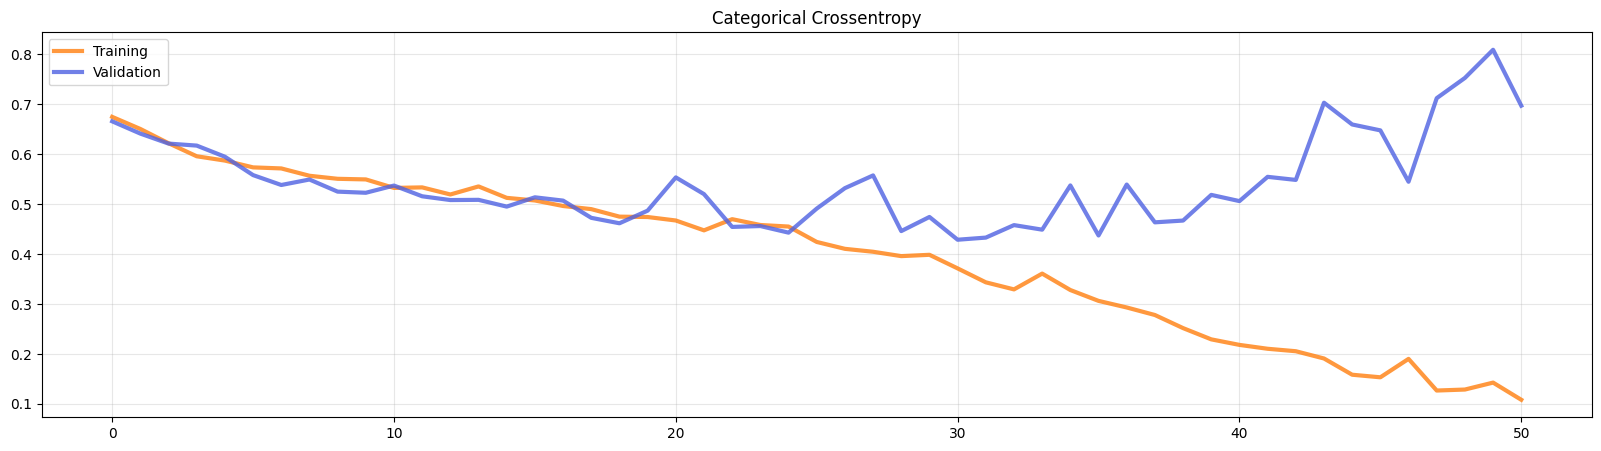

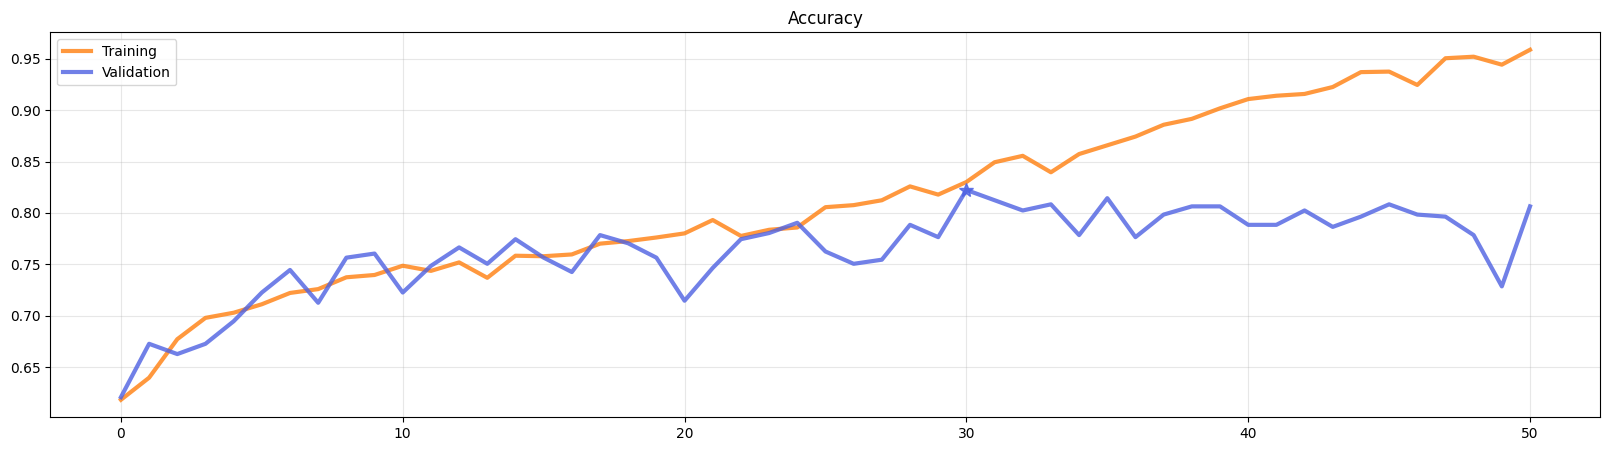

In [53]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [54]:
# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

#predictions now are probabilities
#convert in 0 and 1
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (501, 1)


Accuracy: 0.7904
Precision: 0.8073
Recall: 0.7452
F1: 0.7577


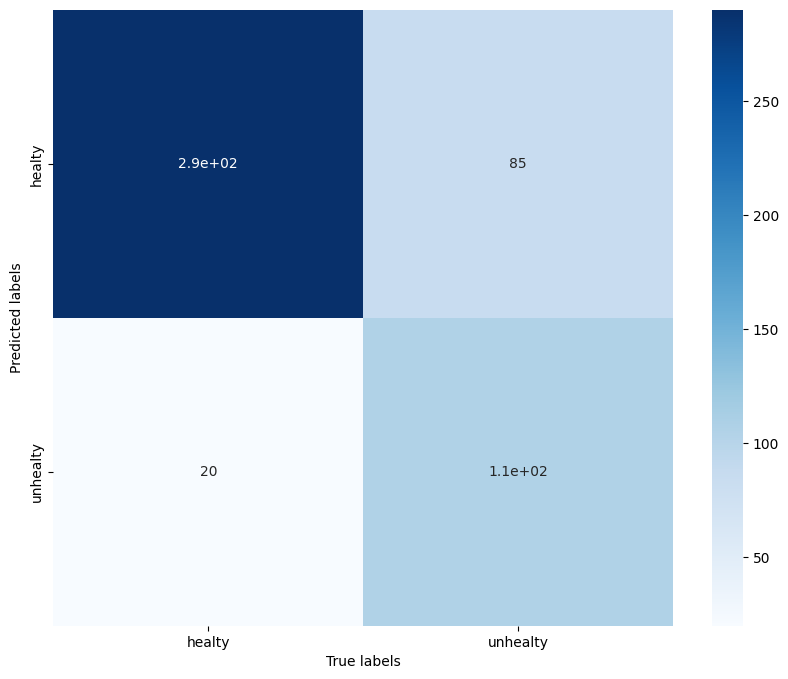

In [55]:
# Compute the confusion matrix
cm = confusion_matrix(y_test,binary_predictions)

# Compute classification metrics
accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions, average='macro')
recall = recall_score(y_test, binary_predictions, average='macro')
f1 = f1_score(y_test, binary_predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
model.save('CustomCNN_saved')